In [1]:
import os
import sys
sys.path.append("..")
import argparse
from tqdm import tqdm
from common_utils import *
from GameFormer.data_utils import *
import matplotlib.pyplot as plt
from nuplan.planning.utils.multithreading.worker_parallel import SingleMachineParallelExecutor
from nuplan.planning.scenario_builder.scenario_filter import ScenarioFilter
from nuplan.planning.scenario_builder.nuplan_db.nuplan_scenario_builder import NuPlanScenarioBuilder
from nuplan.planning.scenario_builder.nuplan_db.nuplan_scenario_utils import ScenarioMapping

In [2]:
data_path = '/data/fyy/GameFormer-Planner/nuplan/dataset/data/cache/train_boston'
map_path = '/data/fyy/GameFormer-Planner/nuplan/dataset/maps'
scenarios_per_type = 1000
total_scenarios = None
shuffle_scenarios = False
debug = False
map_version = "nuplan-maps-v1.0"
sensor_root = None
db_files = None


In [3]:
scenario_mapping = ScenarioMapping(scenario_map=get_scenario_map(), subsample_ratio_override=0.5)
builder = NuPlanScenarioBuilder(data_path, map_path, sensor_root, db_files, map_version, scenario_mapping=scenario_mapping)

scenario_filter = ScenarioFilter(*get_filter_parameters(scenarios_per_type, total_scenarios, shuffle_scenarios))
worker = SingleMachineParallelExecutor(use_process_pool=True)
scenarios = builder.get_scenarios(scenario_filter, worker)
print(f"Total number of scenarios: {len(scenarios)}")


Total number of scenarios: 10777


In [5]:
idx = 0
scenario = scenarios[idx]
# nuplan/nuplan-devkit/nuplan/planning/scenario_builder/nuplan_db/nuplan_scenario.py
map_name = scenario._map_name
token = scenario.token
map_api = scenario.map_api 
log_name = scenario.log_name
print(f"Scenario: {scenario}")
print(f"Map name: {map_name}")
print(f"Scenario token: {token}")
print(f"Map API: {map_api}")

Scenario: <nuplan.planning.scenario_builder.nuplan_db.nuplan_scenario.NuPlanScenario object at 0x7f5739a53580>
Map name: us-ma-boston
Scenario token: 0008836f94845f11
Map API: <nuplan.common.maps.nuplan_map.nuplan_map.NuPlanMap object at 0x7f5780392a60>


## traj

In [6]:
past_time_horizon = 2 # [seconds]
num_past_poses = 10 * past_time_horizon 
future_time_horizon = 8 # [seconds]
num_future_poses = 10 * future_time_horizon
num_agents = 20

def get_ego_agent():
    anchor_ego_state = scenario.initial_ego_state
    
    past_ego_states = scenario.get_ego_past_trajectory(
        iteration=0, num_samples=num_past_poses, time_horizon=past_time_horizon
    )
    
    sampled_past_ego_states = list(past_ego_states) + [anchor_ego_state]
    past_ego_states_tensor = sampled_past_ego_states_to_tensor(sampled_past_ego_states)

    past_time_stamps = list(
        scenario.get_past_timestamps(
            iteration=0, num_samples=num_past_poses, time_horizon=past_time_horizon
        )
    ) + [scenario.start_time]

    past_time_stamps_tensor = sampled_past_timestamps_to_tensor(past_time_stamps)

    return past_ego_states_tensor, past_time_stamps_tensor

def get_neighbor_agents():
    present_tracked_objects = scenario.initial_tracked_objects.tracked_objects
    past_tracked_objects = [
        tracked_objects.tracked_objects
        for tracked_objects in scenario.get_past_tracked_objects(
            iteration=0, time_horizon=past_time_horizon, num_samples=num_past_poses
        )
    ]

    sampled_past_observations = past_tracked_objects + [present_tracked_objects]
    past_tracked_objects_tensor_list, past_tracked_objects_types = \
            sampled_tracked_objects_to_tensor_list(sampled_past_observations)

    return past_tracked_objects_tensor_list, past_tracked_objects_types

ego_agent_past, time_stamps_past = get_ego_agent()
neighbor_agents_past, neighbor_agents_types = get_neighbor_agents()

# 只能运行一次
ego_agent_past, neighbor_agents_past, neighbor_indices = \
    agent_past_process(ego_agent_past, time_stamps_past, neighbor_agents_past, neighbor_agents_types, num_agents)


(21, 11)


(-50.606333541870114,
 50.94893913269043,
 -25.09824686050415,
 22.636662769317628)

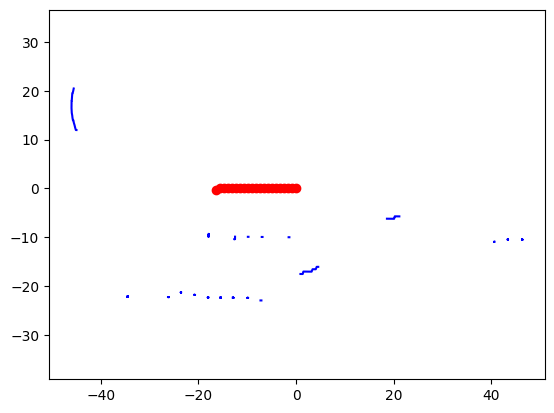

In [8]:
i = 10
traj = neighbor_agents_past[i]  # batch = 1
print(traj.shape)

for i in range(len(ego_agent_past)):
    plt.scatter(ego_agent_past[i][0], ego_agent_past[i][1], c='r')
    
for j in range(20):
    traj = neighbor_agents_past[j]
    # print(traj[0][0])
    if traj[0][0] == 0 or traj[0][1] == 0:
        continue
    plt.plot(traj[:, 0], traj[:, 1], 'b')
        


In [11]:
from map_utils import  PGPGraphMapFeatureBuilder 
pgp_map_feature_builder = PGPGraphMapFeatureBuilder(map_extent=[-20, 80, -50, 50], polyline_resolution=1, polyline_length=20)
pgp_graph_map = pgp_map_feature_builder.get_features_from_scenario(scenario)


(38, 20, 7)


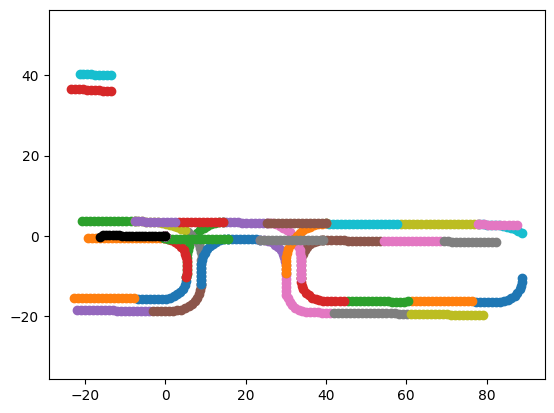

In [20]:
lane_node_feats_arry = pgp_graph_map.lane_node_feats
print(lane_node_feats_arry.shape)
for i in range(len(lane_node_feats_arry)):
    plt.scatter(pgp_graph_map.lane_node_feats[i, :, 0], pgp_graph_map.lane_node_feats[i, :, 1])
plt.axis('equal')

for i in range(len(ego_agent_past)):
    plt.scatter(ego_agent_past[i][0], ego_agent_past[i][1], c='black')


In [46]:
from route_utils import get_correct_route_roadblock_ids 

route_roadblock_ids = scenario.get_route_roadblock_ids()
ego_state = scenario.initial_ego_state
route_roadblock_ids = get_correct_route_roadblock_ids(
    route_roadblock_ids=route_roadblock_ids,
    ego_pose=ego_state.center,
    map_api=map_api,
)
lanes = pgp_map_feature_builder.get_lanes_around_agent(ego_state, map_api)

In [25]:
polygons = pgp_map_feature_builder.get_polygons_around_agent(ego_state, map_api)
lane_node_feats, lane_node_ids = pgp_map_feature_builder.get_lane_node_feats(ego_state, lanes, polygons)

156 (15, 6)


(-190.83796747388493,
 112.23258631683586,
 -26.162441768034277,
 113.22120032435211)

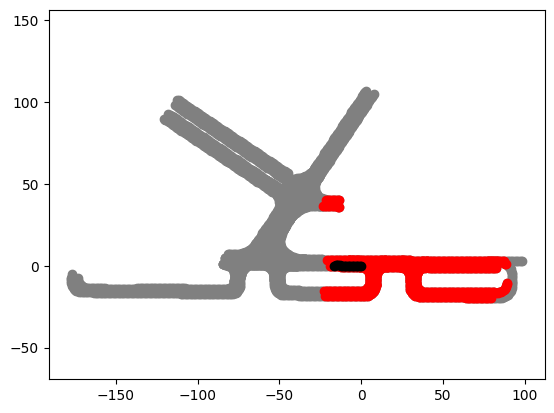

In [49]:
print(len(lane_node_feats), lane_node_feats[7].shape)
for i in range(len(lane_node_feats)):
    plt.scatter(lane_node_feats[i][:, 0], lane_node_feats[i][:, 1], c='grey')
    
for i in range(len(lane_node_feats_arry)):
    plt.scatter(pgp_graph_map.lane_node_feats[i, :, 0], pgp_graph_map.lane_node_feats[i, :, 1], c='r')

for i in range(len(ego_agent_past)):
    plt.scatter(ego_agent_past[i][0], ego_agent_past[i][1], c='black')
    
plt.axis('equal')
